# Differential drive robot (a.k.a., the "segbot")

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt

# This is my own script (it is an interface to the pybullet simulator)
import ae353_segbot

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_segbot)

<module 'ae353_segbot' from 'c:\\Users\\anshu\\Desktop\\Class Materials\\AE 353 Git\\ae353-sp21\\projects\\02_segbot\\ae353_segbot.py'>

Create an instance of the robot simulator. This will open a window in which you should see the segbot.

There are three optional parameters:

* `damping` is the coefficient of viscous friction at each wheel joint (the default value is `0.`)
* `dt` is the length of each time step in the simulator (the default value is `0.01`)
* `display` is a flag that says whether or not to open the GUI (the default value is `True`)

The `display` parameter, in particular, is likely to be of use to you. If you set `display=True`, then you will run the simulator in real-time with a GUI. If you set `display=False`, then you will run the simulator as fast as possible (faster than real-time) without a GUI. This is convenient when all you want is the data.

**NOTE:** it is still necessary to reset the kernel (see the "Kernel" menu above) before creating a new instance of the robot simulator, even when running without a GUI - if you don't, then you'll notice that simulation slows way down.

In [2]:
robot = ae353_segbot.RobotSimulator(damping=0., dt=0.01, display=True)

Define and create an instance of the robot controller. By default, it chooses to apply zero torque both to the gimbal and to the rotor. Modify the `run` function - or anything else in the class definition - to make the controller behave differently.

In [3]:
class RobotController:
    def __init__(self, dt=0.01):
        self.dt = dt    
        
        self.K = np.array([[-2.9580398915498,
  -10.013501342462096,
  -1.0000000000000284,
  -3.9730789890662384,
  -22.99925064982162,
  -4.171856407411919],
 [2.958039891549831,
  10.01350134246214,
  -1.0000000000000568,
  3.97307898906623,
  -22.99925064982162,
  -4.171856407411926]])
        self.v_des = 4
        self.e_l_des = -0.2

    def run(self, lateral_error, heading_error, forward_speed, turning_rate, pitch_angle, pitch_rate):
         # tau_left = -1.5*(6 - forward_speed) + 10*(lateral_error - 0.1) + 20*(heading_error-0) + 5*(turning_rate - 0) + 60*(pitch_angle-0) + 5*(pitch_rate-0)  # <--- torque applied to left wheel (positive means rolling forward)
         # tau_right = -1.5*(6 - forward_speed) -10*(lateral_error - 0.1) - 20*(heading_error-0) - 5*(turning_rate - 0) + 60*(pitch_angle-0) + 5*(pitch_rate-0) # <--- torque applied to right wheel (positive means rolling forward)
        x = np.array([[lateral_error-self.e_l_des], [heading_error], [forward_speed - self.v_des], [turning_rate], [pitch_angle], [pitch_rate]])
        u = -self.K @ x

        tau_left = u[0] # <-- Torque to left wheel
        tau_right = u[1] # <-- Torque to right wheel
        
        return tau_left, tau_right

controller = RobotController(dt=robot.dt)

Run the simulation. It is a loop. At each iteration, we:
* get sensor measurements
* choose actuator commands
* go forward one time step

We also log data so that we can plot it later, if we want.

In [4]:
# Restore the simulation to its initial state
robot.reset(turn_left=False,            # does the robot turn left or right around the track
            ground_pitch=0.0,            # angle that the track is sloped (rad)
            initial_speed=0.0,           # initial forward speed of segbot (m/s)
            initial_lateral_error=0.,   # initial lateral error of segbot (m)
            initial_heading_error=0.,   # initial heading error of segbot (rad)
            initial_pitch=0)           # initial pitch angle of chassis (rad)

# Choose a camera view
# robot.camera_sideview()
# robot.camera_topview()
robot.camera_chaseview(yaw=200.)

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 30.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'lateral_error': np.empty(num_steps, dtype=float),
    'heading_error': np.empty(num_steps, dtype=float),
    'forward_speed': np.empty(num_steps, dtype=float),
    'turning_rate': np.empty(num_steps, dtype=float),
    'pitch_angle': np.empty(num_steps, dtype=float),
    'pitch_rate': np.empty(num_steps, dtype=float),
    'tau_left_command': np.empty(num_steps, dtype=float),
    'tau_right_command': np.empty(num_steps, dtype=float),
    'tau_left': np.empty(num_steps, dtype=float),
    'tau_right': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    (lateral_error,
     heading_error,
     forward_speed,
     turning_rate,
     pitch_angle,
     pitch_rate) = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau_left_command, tau_right_command = controller.run(lateral_error,
                                                         heading_error,
                                                         forward_speed,
                                                         turning_rate,
                                                         pitch_angle,
                                                         pitch_rate)
    
    # Apply the actuator commands
    tau_left, tau_right = robot.set_actuator_commands(tau_left_command, tau_right_command)
    
    # Log the data from this time step
    data['t'][step] = t
    data['lateral_error'][step] = lateral_error
    data['heading_error'][step] = heading_error
    data['forward_speed'][step] = forward_speed
    data['turning_rate'][step] = turning_rate
    data['pitch_angle'][step] = pitch_angle
    data['pitch_rate'][step] = pitch_rate
    data['tau_left_command'][step] = tau_left_command
    data['tau_right_command'][step] = tau_right_command
    data['tau_left'][step] = tau_left
    data['tau_right'][step] = tau_right
    
    # Simulate one time step
    robot.step(t=(start_time + (robot.dt * (step + 1))))

An example of how to plot results. This is just an example!

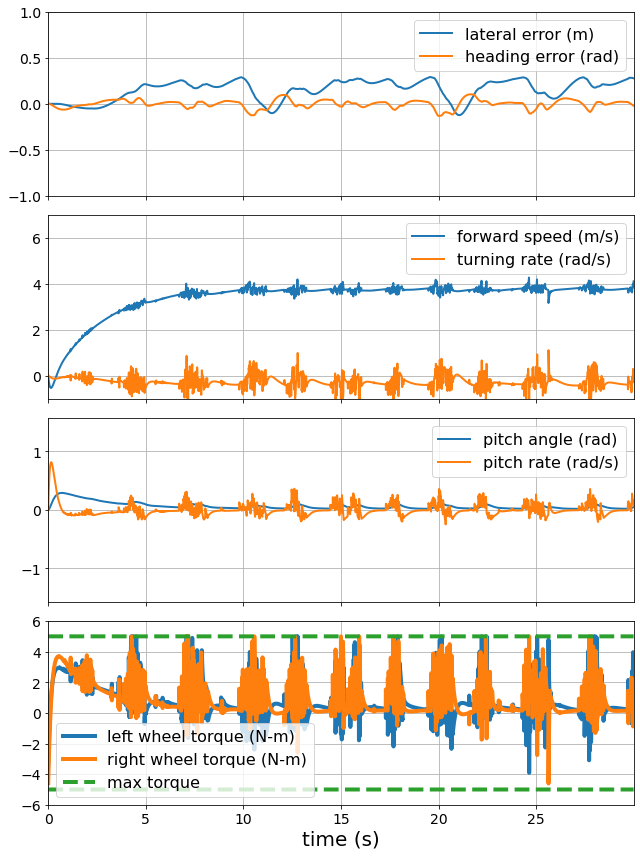

In [5]:
# Create a figure with four subplots, all of which share the same x-axis
fig, ax = plt.subplots(4, 1, figsize=(9, 12), sharex=True)

# First subplot
ax[0].plot(data['t'], data['lateral_error'], label='lateral error (m)', linewidth=2)
ax[0].plot(data['t'], data['heading_error'], label='heading error (rad)', linewidth=2)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)
ax[0].set_ylim(-1, 1)

# Second subplot
ax[1].plot(data['t'], data['forward_speed'], label='forward speed (m/s)', linewidth=2)
ax[1].plot(data['t'], data['turning_rate'], label='turning rate (rad/s)', linewidth=2)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)
ax[1].set_ylim(-1,7)

# Third subplot
ax[2].plot(data['t'], data['pitch_angle'], label='pitch angle (rad)', linewidth=2)
ax[2].plot(data['t'], data['pitch_rate'], label='pitch rate (rad/s)', linewidth=2)
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)
ax[2].set_ylim(-np.pi/2, np.pi/2)

# Fourth subplot
ax[3].plot(data['t'], data['tau_left'], label='left wheel torque (N-m)', linewidth=4)
ax[3].plot(data['t'], data['tau_right'], label='right wheel torque (N-m)', linewidth=4)
ax[3].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max torque', linewidth=4, color='C2')
ax[3].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax[3].grid()
ax[3].legend(fontsize=16)
ax[3].tick_params(labelsize=14)
ax[3].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[3].set_xlabel('time (s)', fontsize=20)
ax[3].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()